In [3]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier

In [57]:
import matplotlib.pyplot as plt

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score, precision_score

In [15]:
# Feature selection 
from sklearn.feature_selection import RFE

In [17]:
# Train , test split
from sklearn.model_selection import train_test_split,cross_val_score

In [25]:
#data=pd.read_csv("predict_user_app_deletion.csv")

In [27]:
from sklearn.datasets import fetch_california_housing

In [29]:
data=fetch_california_housing()

In [47]:
#data

In [43]:
df=pd.DataFrame(data['data'],columns=data['feature_names'])
df['MedHouseVal']=data['target']

In [49]:
df['MedHouseVal_gt_250k']=df['MedHouseVal'].apply(lambda x:1 if x > 2.5 else 0)

In [51]:
df.shape

(20640, 10)

In [63]:
# Implement K means clusetting for AveRoomes,Population, Ave Occup
for point in df.head(5).values:
    print(point.mean())

30.30646920634921
235.98462594024605
48.75522418079096
54.509445616438356
55.04126015444016


In [97]:
def initialize_centroids(X,k):
    """
    Rondomaly intilze k centroids  from the datasets
    """
    indices=np.random.choice(X.shape[0],k, replace=False)

    return X[indices]

def assign_clusters(X, centroids):

    "Assign each data point in X to the nearest centroid"

    clusters=[]

    for point in X:
        distances= [np.linalg.norm(point-centroid) for centroid in centroids]
        clusters.append(np.argmin(distances))

    return np.array(clusters)

def update_centroids(X,clusters,k):

    new_centroids=[]
    for i in range(k):
        cluster_points=X[clusters==i]
        if len(cluster_points)==0:
            new_centroid= X[np.random.randint(0,X.shape[0])]
        else:
            new_centroid=np.mean(cluster_points, axis=0)
        new_centroids.append(new_centroid)

    return np.array(new_centroids)

def k_means(X,k,max_iters=1000,tol=1e-4):
    centroids=initialize_centroids(X,k)
 
    for i in range(max_iters):

        clusters =assign_clusters(X,centroids)
        new_centroids= update_centroids(X,clusters,k)

        if np.all(np.linalg.norm(new_centroids-centroids,axis=1) < tol ):
            print(f"converged after  {i+1} iterations")
            break

        centroids =new_centroids

    return clusters, centroids

In [99]:
df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal', 'MedHouseVal_gt_250k'],
      dtype='object')

In [101]:
X = df[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup','Latitude', 'Longitude']].values

# Set the number of clusters
k = 4  # adjust as needed

# Run k-means clustering on the dataset with 4 features
clusters, centroids = k_means(X, k)

converged after  39 iterations


# Choosing Optimum Number of Clusters

converged after  20 iterations
converged after  28 iterations
converged after  38 iterations
converged after  66 iterations
converged after  95 iterations
converged after  88 iterations
converged after  113 iterations
converged after  125 iterations
converged after  220 iterations


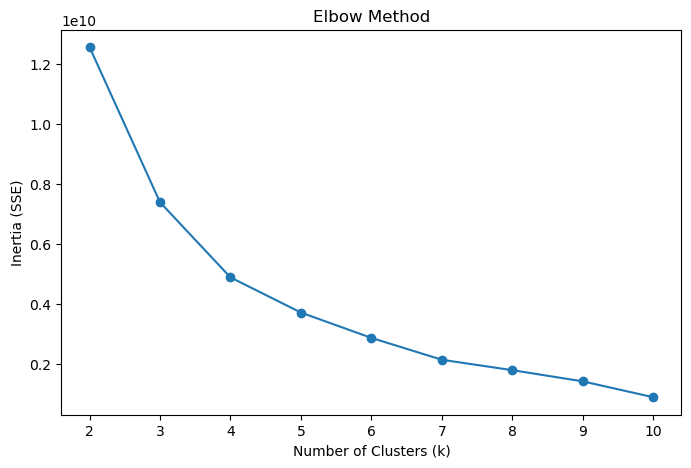

In [119]:
# Range of cluster numbers to try
k_range = range(2, 11)  # for example, trying 2 to 10 clusters
inertias = []

for k in k_range:
    clusters, centroids = k_means(X, k)
    inertia = 0
    for i, centroid in enumerate(centroids):
        # Sum the squared distances for each point in the cluster
        inertia += np.sum(np.linalg.norm(X[clusters == i] - centroid, axis=1) ** 2)
    inertias.append(inertia)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.show()

converged after  21 iterations
converged after  17 iterations
converged after  45 iterations
converged after  66 iterations
converged after  93 iterations
converged after  102 iterations
converged after  109 iterations
converged after  112 iterations
converged after  198 iterations


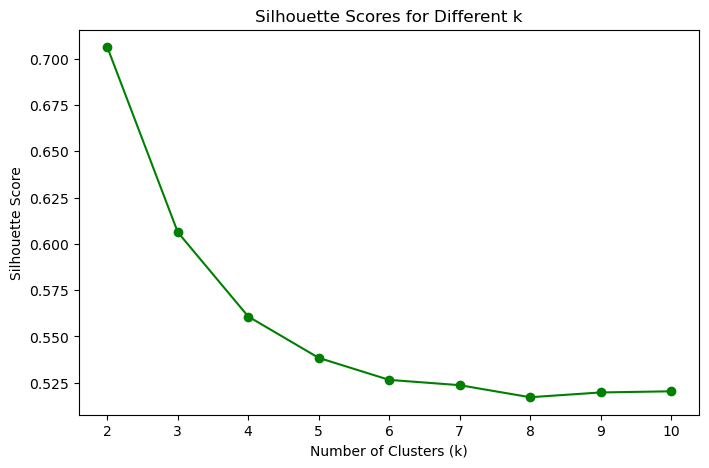

In [124]:
# Can Also be determiend using silhoutte Analysis
"""
The silhouette score measures how similar a point is to its own cluster compared to other clusters.
Scores range from -1 to 1, with higher values indicating better clustering.
You compute the silhouette score for different k values and choose the one with the highest score.
"""

from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in k_range:
    clusters, centroids = k_means(X, k)
    score = silhouette_score(X, clusters)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [132]:
X[clusters==3]

array([[   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   2.4912    ,   29.        ,    3.7248    , ...,    1.8432    ,
          37.81      , -122.25      ],
       [   3.2177    ,   28.        ,    3.87842351, ...,    1.71209085,
          37.81      , -122.25      ],
       ...,
       [   4.1997    ,   17.        ,    5.73275862, ...,    3.08836207,
          38.66      , -121.76      ],
       [   3.4186    ,    6.        ,    5.66256158, ...,    3.15394089,
          38.53      , -121.99      ],
       [   1.3375    ,   18.        ,    4.56762513, ...,    2.8828541 ,
          39.13      , -121.54      ]])